## Classificador hierárquico para características morfométricas de núcleo/citoplasma de células cervicais 

In [4]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 

import functions

In [2]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

In [292]:
# Retorna mapa para contabilizar as predições para cada amostra em cada classe
''' 
def def_map_preds_y(y_test, cls_type):
    if cls_type == 1:  ## normal/anormal
            cls = [0,1]
            map_pred = {0: 0, 1:0} 
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
            map_pred = {1: 0, 2:0} 
    elif cls_type == 3:  ## asc-us/lsil
            cls = [1,3]
            map_pred = {1: 0, 3:0} 
    else:   ## asch/hsil/car
            cls = [2,4,5]
            map_pred = {2: 0, 4:0, 5:0}

    map_preds = np.empty((y_test.shape[0]), dtype= object)        
    for i in range(y_test.shape[0]):   
           map_preds[i] = map_pred.copy()
    return map_preds  

# Registra predições do conjunto de teste:
def set_map_preds_y(map_preds, y_pred, cls_type):
    if cls_type == 1:    ## normal/anormal
            cls = [0,1]
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
    elif cls_type == 3:   ## asc-us/lsil
            cls = [1,3]
    else:   ## asch/hsil/car
            cls = [2,4,5]
    for i, pred in enumerate(y_pred):
        if pred in cls:
           map_preds[i][pred]= map_preds[i][pred] + 1 
        else:
            print("**Predição de outra classe ", pred, ' tipo classificado: ', cls_type)

# Define predições para o conjunto de teste, considerando a classe mais votada:
def finalize_preds_y(map_preds, cls_type):
    preds = np.zeros(map_preds.shape[0])
    if cls_type == 1:    ## normal/anormal
          cls = [0,1]
    elif cls_type == 2:   ## baixo/alto grau
            cls = [1,2]
    elif cls_type == 3:   ## asc-us/lsil
            cls = [1,3]
    else:   ## asch/hsil/car
            cls = [2,4,5]
            
    if cls_type != 4:
        for i, map_pred in enumerate(map_preds):    
               if (map_pred[cls[0]] > map_pred[cls[1]]):
                    preds[i] = cls[0] 
               elif (map_pred[cls[0]] < map_pred[cls[1]]):  
                    preds[i] = cls[1]
               else:  # Não houve classe majoritária 
                    preds[i] = -1  
    else:  ## classificador 4 (ternário)
        for i, map_pred in enumerate(map_preds):    
               if ((map_pred[cls[0]] > map_pred[cls[1]]) and (map_pred[cls[0]] > map_pred[cls[2]])):
                   preds[i] = cls[0] 
               elif (map_pred[cls[1]] > map_pred[cls[2]]):
                    preds[i] = cls[1]
               elif (map_pred[cls[1]] < map_pred[cls[2]]):
                    preds[i] = cls[2]
               else:  # Não houve classe majoritária
                    preds[i] = -1       
    return preds
'''

### Features:

In [8]:
len(functions.list_all_features(20)), len(functions.list_all_nucleus_features(20)), len(functions.list_all_cyto_features(20)), len(functions.list_all_EFD_features(20))


(200, 98, 98, 154)

### Lê arquivo (features):

In [10]:
N_EFD_COEFFS = 20

In [11]:
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = functions.normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [12]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [13]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [15]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= functions.get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       functions.list_all_features(N_EFD_COEFFS))
 

#### Tuning de parâmetros (Classificador) 
Feito apenas uma vez com um subconjunto dos dados e para cada um dos métodos (SVM, RF e XGBOOST). 

Conjunto de dados para tuning:

   X: merge de todas as features selecionadas para o classificador hierarquico (classificadores 1,2,3, e 4) 
  
   y: rótulos das 6 classes Bethesda.

In [16]:
# Separa dados para treino/validação e teste:
(X_train, X_test, y_train, y_test, image_cells_ids_train, image_cells_ids_test) = train_test_split(data, target, image_cells_ids, test_size=0.2, random_state=45)

#Separa dados para tuning de parâmetros dos modelos:
_, X_train_tuning, _, y_train_tuning = train_test_split(X_train, y_train, test_size=0.5, random_state=45)
Counter(y_test['bethesda'].values),  Counter(y_train_tuning['bethesda'].values)

(Counter({1.0: 44, 2.0: 107, 0.0: 172, 3.0: 127, 5.0: 13, 4.0: 184}),
 Counter({2.0: 212, 4.0: 363, 1.0: 118, 0.0: 336, 3.0: 228, 5.0: 36}))

In [ ]:
#best_features_spfsr_1, feature_importances_spfsr_1 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=1), N_FEATURES = None)
#best_features_spfsr_2, feature_importances_spfsr_2 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=2), N_FEATURES = None)
#best_features_spfsr_3, feature_importances_spfsr_3 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=3), N_FEATURES = None)
#best_features_spfsr_4, feature_importances_spfsr_4 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=4), N_FEATURES = None)

In [124]:
#features_sel = list(set(best_features_spfsr_1.tolist() + best_features_spfsr_2.tolist() +
#                        best_features_spfsr_3.tolist() + best_features_spfsr_4.tolist()))
#len(features_sel), #features_sel 

(75,)

In [287]:
svm_params = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree":[2,3,4], "gamma": [1e-3, 1e-4], "coef0":[2e-1, 2e-2] , "C": [1, 10, 100, 1000]},
]
#svm_param =  grid_search_SVM(SVC(), svm_params, X_train[features_sel], y_train['bethesda'])
#print('Best svm params: ', svm_param)

In [288]:
rf_params = {'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 50, 100, 150]
            }
#rf_param = grid_search_RF(RandomForestClassifier(random_state=0),
#                             rf_params, X_train[features_sel], y_train['bethesda'])
#print('Best Random Forest params: ', rf_param)

In [289]:
xgb_params = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0, 0.3, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7]
        }


#xgb_param, result = grid_search_XGB(xgb.XGBClassifier(learning_rate=0.2, 
#                                               n_estimators=200, objective='multi:softprob'),
#                                    xgb_params, X_train[features_sel], y_train['bethesda'])
#print('Best XGBoost params: ', xgb_param)                

In [28]:
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100}
xgb_param = {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.5, 'colsample_bytree': 0.8}

In [29]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]
features = list_all_features(N_EFD_COEFFS)
print(f'Nº total de de features: {len(features)}')

Nº total de de features: 200


In [30]:
#### Aplica seleção de features (executada em separado): classificadores (1, 2, 3, 4)
best_features_spfsr_1 =  ['ratio_NC','ratio_NC_per', 'eN', 'ratio_NC_hArea', 'ardN']
best_features_MI_1 =  ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'mrdN', 'eN', 'maxAxN', 'periN',
                       'ardN', 'hAreaN', 'equidiaN', 'areaN', 'fdN', 'compacC', 'circuC', 'riN', 'areaC',
                       'periC', 'hAreaC', 'minAxC', 'maxAxC', 'ardC', 'fdC', 'mrdC', 'equidiaC', 'eC',
                       'circuN', 'compacN', 'riC', 'minAxN', 'convexN']
best_features_spfsr_2 =  ['areaC', 'fdC', 'eC', 'ratio_NC', 'ratio_NC_hArea', 'maxAxC', 'equidiaC', 'mrdC',
                          'compacC', 'periC']
best_features_MI_2 =  ['areaC', 'equidiaC', 'fdC', 'hAreaC', 'ardC', 'periC', 'ratio_NC_hArea', 'ratio_NC',
                         'mrdC', 'maxAxC', 'eC', 'ratio_NC_per', 'riC', 'minAxC', 'circuC', 'compacC',
                         'equidiaN', 'areaN', 'fdN', 'hAreaN', 'riN', 'periN', 'minAxN','nucleus_position',
                         'ardN', 'solidC', 'maxAxN', 'extentC', 'mrdN', 'eN']  
best_features_spfsr_3 =  ['solidN', 'nucleus_position', 'efdC55', 'efdN41', 'compacN', 'periC', 'efdN40', 'eccenN',
                         'extentC', 'efdN63', 'efdN3', 'efdN43', 'efdN38', 'efdC17', 'efdC54','efdN48', 'efdN69',
                         'circuN', 'efdN9', 'efdC71', 'efdN15', 'efdN58', 'elonC', 'efdN76', 'efdN19',
                         'efdN22', 'efdN14', 'efdC8', 'efdC4', 'efdC63']
best_features_MI_3 = ['efdC31', 'efdC39', 'efdC33', 'efdN76', 'efdN12', 'efdN39', 'efdC41', 'efdC14', 'efdC51',
                      'mrdN', 'efdC63', 'efdC4', 'efdN33', 'extentN', 'minAxN', 'efdN55', 'efdC44', 'efdN15',
                      'efdN2', 'fdC', 'efdN25', 'efdC1', 'efdC66', 'efdC34','circuC', 'efdN65', 'efdN62',
                      'efdC18', 'efdN74', 'efdC40']
best_features_spfsr_4 =  ['ratio_NC_per', 'ratio_NC', 'ratio_NC_hArea', 'areaC', 'efdN51', 'minAxC', 'efdC38',
                          'efdC18', 'efdN27', 'efdN14'] 
best_features_MI_4 =  ['ratio_NC', 'ratio_NC_hArea', 'ratio_NC_per', 'areaC', 'periC', 'mrdC', 'eC', 'compacC',
                       'solidC', 'circuC', 'ardC', 'extentC', 'maxAxC', 'eccenC', 'nucleus_position', 'raC',
                       'riC', 'hAreaC', 'convexC', 'convexN', 'efdC62', 'efdC52', 'efdC2', 'extentN', 'efdC32',
                       'efdC74', 'efdC33', 'efdC6', 'raN', 'efdC54']
 

In [31]:
len(best_features_MI_4), len(best_features_spfsr_4)

(30, 10)

## Experiment nº1:   features (nucleus + cytoplasm)

In [32]:
features_desc = "Selected features to nucleus and cytoplasm"
N_FEATURES = 30
N_ITER = 30
 
accs = precs = recs = specs = f1_scores = aucs = np.zeros((3))

labels_list_bin = [] 
roc_curve_list_bin = []

preds_to_conf_matrix_bin= []
preds_to_conf_matrix_ter= []
preds_to_conf_matrix_bet= []

results_bin = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_ter = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
results_bet = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])

mean_fpr = np.linspace(0, 1, 100)


In [33]:
# Prepara array para registro de predições (classific. binário, ternário e bethesda) separado por algoritmos:
preds_bin = np.ones((data.shape[0],3))*-1
probs_bin = np.zeros((data.shape[0],3,2))
 
preds_ter = np.ones((data.shape[0],3))*-1
probs_ter = np.zeros((data.shape[0],3,2))

preds_bet = np.ones((data.shape[0],3))*-1
probs_bet = np.zeros((data.shape[0],3,2))

In [34]:
le_2 = preprocessing.LabelEncoder()
le_2.fit([1,2])
le_3 = preprocessing.LabelEncoder()
le_3.fit([1,3])
le_4 = preprocessing.LabelEncoder()
le_4.fit([2,4,5])

LabelEncoder()

In [35]:
# Loop principal:  (cross_val )

cv = StratifiedKFold(n_splits=N_ITER, random_state=None)

# Split com rótulos Bethesda para um split estratificado (cada iteração executa todos os classificadores de 1 à 4)
# Separa dados para treino/validação e teste:
for it, (idx_train, idx_test) in enumerate(cv.split(data.values, target['bethesda'].values)):
    print('Iteração número: ', it)

    # Filtra apenas features selecionadas
    X_train = data[best_features_spfsr_1].values[idx_train]
    y_train = target['binary'].values[idx_train]
    
    X_test = data[best_features_spfsr_1].values[idx_test]
    y_test = target['binary'].values[idx_test]
                                                   
    ## treino e teste dos modelo (classificador 1):
    for i in range(3):   
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train, y_train, model, cls_type= 1)
        # Predição:
        pred_y = np.empty(len(idx_test)) 
        pred_y = model.predict(X_test)
        prob_y = model.predict_proba(X_test)

        # Registra predições:
        preds_bin[idx_test, i] = pred_y
        probs_bin[idx_test, i] = prob_y
        
        # Registra predições (classicações ternária/bethesda):
        idx_0 = index_pred_from_class(idx_test, pred_y, cls=0)
        preds_ter[idx_0, i] =  preds_bin[idx_0, i]
        probs_ter[idx_0, i] =  probs_bin[idx_0, i] 
        preds_bet[idx_0, i] =  preds_bin[idx_0, i]
        probs_bet[idx_0, i] =  probs_bin[idx_0, i]  
        
        #print('target_idx_:', target['ternary'].loc[idx_test])
        #print('pred in bin:', preds_bin[idx_test, i])
        #print('pred in ter:', preds_ter[idx_test, i])

    ##------------ X ------------- 
    ## Classificador 2: lesões de alto/baixo grau
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos ternários 1 e 2, filtrando 
    # apenas features selecionadas para o classificador 2
    X_df_train2, y_df_train2 = filter_dataXY(data[best_features_spfsr_2].loc[idx_train],
                                       target.loc[idx_train], 2)
    X_train2, y_train2 = X_df_train2.values,  y_df_train2.values
        
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 1
        # Teste: filtra amostras de rótulos 1 das predições do classificador 1  
        idx_test2, X_df_test2, y_df_test2 = filter_Xy_from_cls1_to_cls2(data[best_features_spfsr_2].loc[idx_test],
                                                        target.loc[idx_test], preds_bin[:,i], idx_test)
        
        X_test2, y_test2= X_df_test2.values, y_df_test2.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train2, y_train2, model, cls_type= 2)
        #print('metricas :', i, metr)
        
        # Predição:
        pred2_y = np.empty(len(idx_test2))
        pred2_y = model.predict(X_test2)
        pred2_y = le_2.inverse_transform(pred2_y)
        #prob_y = model.predict_proba(X_test2)

        # Registra predições:
        preds_ter[idx_test2, i] = pred2_y
        #probs_ter[idx_test2, i] = prob_y
        
        
    ##------------ X ------------- 
    ## Classificador 3: ASC-US/LSIL
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 1 e 3, filtrando 
    # apenas features selecionadas para o classificador 3
    X_df_train3, y_df_train3 = filter_dataXY(data[best_features_spfsr_3].loc[idx_train],
                                       target.loc[idx_train], 3)
    X_train3, y_train3 = X_df_train3.values,  y_df_train3.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 1 (lesão de baixo grau) das predições dos classificadores 2  
        idx_test3, X_df_test3, y_df_test3 = filter_Xy_from_cls1_to_cls3(data[best_features_spfsr_3].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test3, y_test3= X_df_test3.values, y_df_test3.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'binary')
        metr, model = fit_model(X_train3, y_train3, model, cls_type= 3)
        print('--metricas Classificador 3 :', i, metr)
        
        # Predição:
        pred3_y = np.empty(len(idx_test3))
        pred3_y = model.predict(X_test3)
        pred3_y = le_3.inverse_transform(pred3_y)
        #prob_y = model.predict_proba(X_test3)

        # Registra predições:
        preds_bet[idx_test3, i] = pred3_y
        #probs_bet[idx_test3, i] = prob_y
        
    ##------------ X ------------- 
    ## Classificador 4: ASC-H/HSIL/Car
    
    ## Seleciona amostras para treino/teste
    # Treino: seleciona apenas amostras do conjunto de treino para rótulos bethesda 2,4,5, filtrando 
    # apenas features selecionadas para o classificador 4
    X_df_train4, y_df_train4 = filter_dataXY(data[best_features_spfsr_4].loc[idx_train],
                                       target.loc[idx_train], 4)
    X_train4, y_train4 = X_df_train4.values,  y_df_train4.values
    
    
    for i in range(3):   
        ## Obtem dados para teste de acordo com a predição de cada modelo do classificador 2
        # Filtra amostras de rótulos 2(lesão de alto grau) das predições dos classificadores 2  
        idx_test4, X_df_test4, y_df_test4 = filter_Xy_from_cls2_to_cls4(data[best_features_spfsr_4].loc[idx_test],
                                                        target.loc[idx_test], preds_ter[:,i], idx_test)
        
        X_test4, y_test4= X_df_test4.values, y_df_test4.values
 
        ## Obtem modelo
        model = getModel(params= params[i], classifier = classifiers[i], class_type = 'ternary')
        metr, model = fit_model(X_train4, y_train4, model, cls_type= 4)
        print('metricas :', i, metr)
        
        # Predição:
        pred4_y = np.empty(len(idx_test4))
        pred4_y = model.predict(X_test4)
        pred4_y = le_4.inverse_transform(pred4_y)
        #prob_y = model.predict_proba(X_test4)

        # Registra predições:
        preds_bet[idx_test4, i] = pred4_y
        #probs_bet[idx_test4, i] = prob_y
 
## Resultados - classificação binária (normal/anormal):
# Calcula curva_roc e AUC:
for i in range(3):   
    prob = probs_bin[:, i, 1]
    fpr, tpr, thresholds = roc_curve(target['binary'].values, prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    aucs[i]= auc(mean_fpr, interp_tpr)
    labels_list_bin.append(r"ROC Curve (AUC %s= %0.4f)" % ((classifiers[i]+"- normal/anormal"), aucs[i]))
    roc_curve_list_bin.append((mean_fpr, interp_tpr))
    
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='acc', class_type='binary', pos_label=1, classes=[0,1])
    precs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='prec',class_type='binary')                
    recs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='rec',class_type='binary')                
    specs[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='spec',class_type='binary')                
    f1_scores[i] = calc_metric(target['binary'].values, preds_bin[:,i], metric_type='f1_score',class_type='binary')        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bin, class_type='1- Normal/Anormal')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bin.append((target['binary'].values, preds_bin[:,i], "1. Normal/Anormal -"+str(classifiers[i])))
            
  
## Resultados - classificação ternária (normal/baixo grau/ alto grau)
# Calcula métricas e matrix de confusão:
for i in range(3):       
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='acc', class_type='ternary', classes=[0,1,2])
    precs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='prec',class_type='ternary', classes=[0,1,2])                
    recs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='rec',class_type='ternary', classes=[0,1,2])                
    specs[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='spec',class_type='ternary', classes=[0,1,2])                
    f1_scores[i] = calc_metric(target['ternary'].values, preds_ter[:,i], metric_type='f1_score',class_type='ternary', classes=[0,1,2])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_ter, class_type='2- Normal/Low G./High G.')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_ter.append((target['ternary'].values, preds_ter[:,i], "2- Normal/Low G./High G. -"+str(classifiers[i])))

    
## Resultados - classificação bethesda (normal/ascus/asch/lsil/hsil/car)
# Calcula métricas e matrix de confusão:
for i in range(3):   
    # Calcula e registra métricas p/ fold:
    accs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='acc', class_type='bethesda', classes=[0,1,2,3,4,5])
    precs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='prec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    recs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='rec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    specs[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='spec',class_type='bethesda', classes=[0,1,2,3,4,5])                
    f1_scores[i] = calc_metric(target['bethesda'].values, preds_bet[:,i], metric_type='f1_score',class_type='bethesda', classes=[0,1,2,3,4,5])        
    # Acumula métricas no dataframe de resultados e agrupa curvas ROC para exibição:
    metrics= {'Model': classifiers[i], 'acc': accs[i], 'prec': precs[i], 'rec': recs[i], 
              'spec': specs[i], 'f1_score': f1_scores[i], 'AUC': aucs[i]}                                      
    fill_line_metrics_CV(classifiers[i], features_desc, i, metrics, results_bet, class_type='3- Bethesda')            
    # Acumula Matrizes de confusão:  https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix
    preds_to_conf_matrix_bet.append((target['bethesda'].values, preds_bet[:,i], "3- Bethesda -"+str(classifiers[i])))
   

Iteração número:  0
--metricas Classificador 3 : 0 {'acc': 0.686046511627907, 'prec': 0.8205128205128205, 'rec': 0.6153846153846154, 'spec': 0.7941176470588235, 'f1_score': 0.7032967032967034}
--metricas Classificador 3 : 1 {'acc': 0.6976744186046512, 'prec': 0.75, 'rec': 0.75, 'spec': 0.6176470588235294, 'f1_score': 0.75}
--metricas Classificador 3 : 2 {'acc': 0.7209302325581395, 'prec': 0.7592592592592593, 'rec': 0.7884615384615384, 'spec': 0.6176470588235294, 'f1_score': 0.7735849056603773}
metricas : 0 {'acc': 0.6597222222222222, 'prec': 0.6563670411985019, 'rec': 0.6597222222222222, 'spec': 0.7774423804609563, 'f1_score': 0.6574900793650794}
metricas : 1 {'acc': 0.7013888888888888, 'prec': 0.7294516469307202, 'rec': 0.7013888888888888, 'spec': 0.8116959064327486, 'f1_score': 0.7034769572420175}
metricas : 2 {'acc': 0.625, 'prec': 0.6162154377880185, 'rec': 0.625, 'spec': 0.7492604059167527, 'f1_score': 0.6195564516129033}
Iteração número:  1
--metricas Classificador 3 : 0 {'acc': 

--metricas Classificador 3 : 2 {'acc': 0.6162790697674418, 'prec': 0.6451612903225806, 'rec': 0.7843137254901961, 'spec': 0.37142857142857144, 'f1_score': 0.7079646017699115}
metricas : 0 {'acc': 0.625, 'prec': 0.629896099549714, 'rec': 0.625, 'spec': 0.7601583989419622, 'f1_score': 0.6269235421085928}
metricas : 1 {'acc': 0.6458333333333334, 'prec': 0.6849484427609427, 'rec': 0.6458333333333334, 'spec': 0.7892260211625605, 'f1_score': 0.6516161416674895}
metricas : 2 {'acc': 0.6180555555555556, 'prec': 0.6355445906432747, 'rec': 0.6180555555555556, 'spec': 0.7642140000559331, 'f1_score': 0.6238803618433248}
Iteração número:  9
--metricas Classificador 3 : 0 {'acc': 0.627906976744186, 'prec': 0.6938775510204082, 'rec': 0.6666666666666666, 'spec': 0.5714285714285714, 'f1_score': 0.6799999999999999}
--metricas Classificador 3 : 1 {'acc': 0.6046511627906976, 'prec': 0.6349206349206349, 'rec': 0.7843137254901961, 'spec': 0.34285714285714286, 'f1_score': 0.7017543859649124}
--metricas Class

metricas : 1 {'acc': 0.6458333333333334, 'prec': 0.6676257659134373, 'rec': 0.6458333333333334, 'spec': 0.7805744329781582, 'f1_score': 0.6507020790120985}
metricas : 2 {'acc': 0.6319444444444444, 'prec': 0.6315105099457937, 'rec': 0.6319444444444444, 'spec': 0.7573933188809411, 'f1_score': 0.6309727435035317}
Iteração número:  17
--metricas Classificador 3 : 0 {'acc': 0.5930232558139535, 'prec': 0.66, 'rec': 0.6470588235294118, 'spec': 0.5142857142857142, 'f1_score': 0.6534653465346535}
--metricas Classificador 3 : 1 {'acc': 0.6162790697674418, 'prec': 0.640625, 'rec': 0.803921568627451, 'spec': 0.34285714285714286, 'f1_score': 0.7130434782608696}
--metricas Classificador 3 : 2 {'acc': 0.6046511627906976, 'prec': 0.6349206349206349, 'rec': 0.7843137254901961, 'spec': 0.34285714285714286, 'f1_score': 0.7017543859649124}
metricas : 0 {'acc': 0.6319444444444444, 'prec': 0.6343663761801017, 'rec': 0.6319444444444444, 'spec': 0.7638820100192428, 'f1_score': 0.6327371589498131}
metricas : 1

--metricas Classificador 3 : 0 {'acc': 0.5813953488372093, 'prec': 0.6739130434782609, 'rec': 0.5961538461538461, 'spec': 0.5588235294117647, 'f1_score': 0.6326530612244897}
--metricas Classificador 3 : 1 {'acc': 0.6046511627906976, 'prec': 0.6551724137931034, 'rec': 0.7307692307692307, 'spec': 0.4117647058823529, 'f1_score': 0.6909090909090909}
--metricas Classificador 3 : 2 {'acc': 0.6046511627906976, 'prec': 0.65, 'rec': 0.75, 'spec': 0.38235294117647056, 'f1_score': 0.6964285714285715}
metricas : 0 {'acc': 0.6597222222222222, 'prec': 0.6722222222222222, 'rec': 0.6597222222222222, 'spec': 0.7901960784313725, 'f1_score': 0.6643435351519185}
metricas : 1 {'acc': 0.6944444444444444, 'prec': 0.7110419672919673, 'rec': 0.6944444444444444, 'spec': 0.8136996904024768, 'f1_score': 0.6987219570207935}
metricas : 2 {'acc': 0.625, 'prec': 0.6374131944444446, 'rec': 0.6249999999999999, 'spec': 0.7656346749226007, 'f1_score': 0.6296739853626081}
Iteração número:  26
--metricas Classificador 3 : 

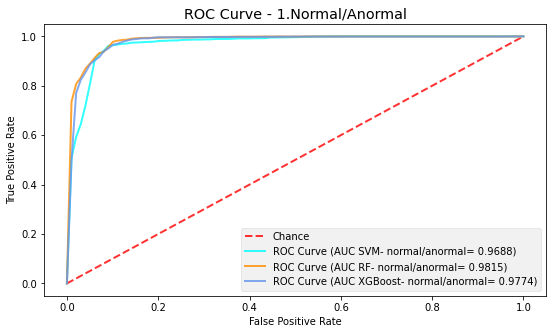

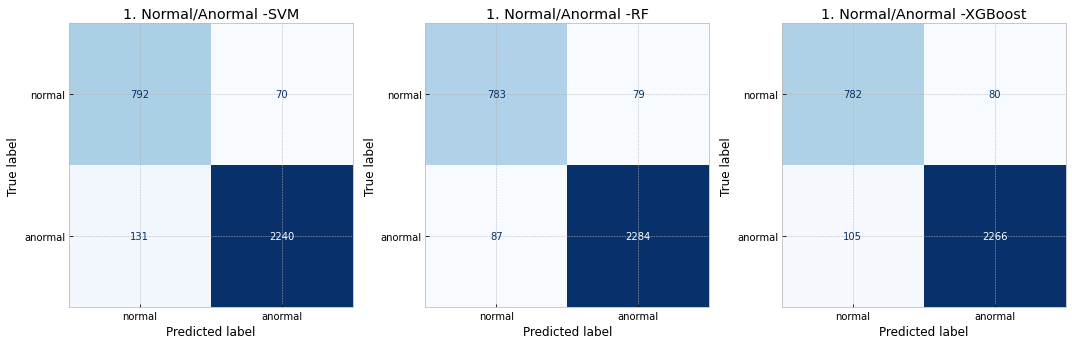

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,1- Normal/Anormal,SVM,Selected features to nucleus and cytoplasm,0.9571,0.9571,0.9571,0.0429,0.9571,0.9571
1,1- Normal/Anormal,RF,Selected features to nucleus and cytoplasm,0.9649,0.9649,0.9649,0.0351,0.9649,0.9649
2,1- Normal/Anormal,XGBoost,Selected features to nucleus and cytoplasm,0.9608,0.9608,0.9608,0.0392,0.9608,0.9608


In [36]:
# Exibe curvas roc, matrizes de confusão e métricas - Classificador binário:
plot_roc_curve_CV(roc_curve_list_bin, labels_list_bin, title = "ROC Curve - 1.Normal/Anormal")
plot_conf_matrix(preds_to_conf_matrix_bin, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results_bin
    

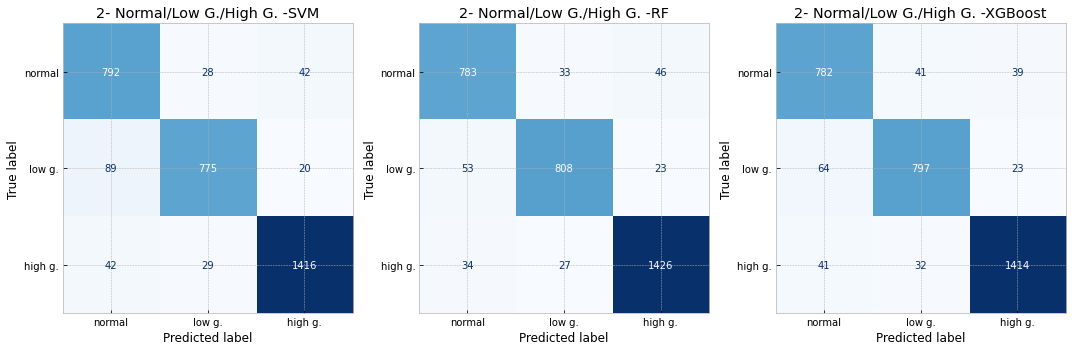

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,2- Normal/Low G./High G.,SVM,Selected features to nucleus and cytoplasm,0.9229,0.9229,0.9229,0.0771,0.9229,0.9229
1,2- Normal/Low G./High G.,RF,Selected features to nucleus and cytoplasm,0.9332,0.9332,0.9332,0.0668,0.9332,0.9332
2,2- Normal/Low G./High G.,XGBoost,Selected features to nucleus and cytoplasm,0.9259,0.9259,0.9259,0.0741,0.9259,0.9259


In [37]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
plot_conf_matrix(preds_to_conf_matrix_ter, lbls=[0,1,2], disp_lbls=['normal','low g.', 'high g.'])
results_ter


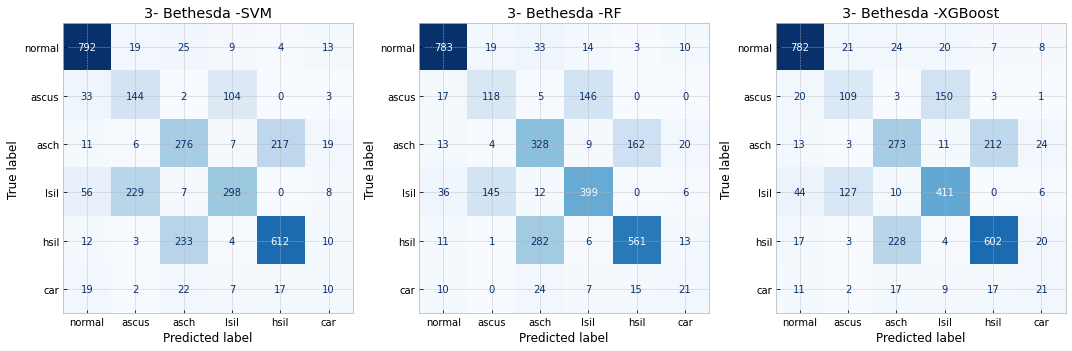

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,3- Bethesda,SVM,Selected features to nucleus and cytoplasm,0.6594,0.6594,0.6594,0.3406,0.6594,0.6594
1,3- Bethesda,RF,Selected features to nucleus and cytoplasm,0.6865,0.6865,0.6865,0.3135,0.6865,0.6865
2,3- Bethesda,XGBoost,Selected features to nucleus and cytoplasm,0.6789,0.6789,0.6789,0.3211,0.6789,0.6789


In [38]:
# Exibe matrizes de confusão e métricas - Classificador ternário:
plot_conf_matrix(preds_to_conf_matrix_bet, lbls=[0,1,2,3,4,5], disp_lbls=['normal','ascus', 'asch', 'lsil', 'hsil', 'car'])
results_bet